## **Carga de librerias y configuraciones**

In [12]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? Y


In [16]:
!cat /proc/meminfo

OSError: [Errno 12] Cannot allocate memory

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import time
import json
import gzip

from sklearn import preprocessing as prp
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (accuracy_score, r2_score, confusion_matrix,
f1_score, recall_score, precision_score)

import os
import boto3
import re

import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

# ruta de trabajo en s3
bucket = 'boi-banregio'

# s3 resource
s3_bucket_resource = boto3.resource('s3').Bucket(bucket)

In [4]:
# Aquí colocamos la ruta de nuestro directorio, el nombre de nuestro archivo y si tiene o no cabecera
prefix = 'datalake/data/InteligenciaRiesgos/M&M/MCV'

data_file_name = "JAT_MCV_UNIVERSO_MODELOADO_FILTROS.csv"
data_file_name2 = "JAT_MCV_VAR_VP2_2/000000_0"
data_file_name3 = "LGG_MCV_VAR_CR_2/000000_0"

header_file_name = "JAT_MCV_UNIVERSO_MODELADO_PREVIO_labels.csv"
header_file_name2 = "LABELS/JAT_MCV_VAR_VP2_LABELS.csv"
header_file_name3 = "LABELS/LGG_MCV_VAR_CR_LABELS.csv"

# Los archivos vienen con o sin encabezado
header = False

target = 'BMI'
# features =  ['pclass', 'age', 'sibsp', 'parch', 'fare']

# Decidimos si se desea imputar valores nulos con media, mediana o moda de las columnas
# en caso de no querer imputar debe tomarse en cuenta que este algoritmo no funciona con valores nulos
impute = True
strategy = 'mean'   # mean, meadian, most_frequent

# Decidimos si queremos escalar las columnas de caracteríticas de tal forma que posean una distribución normal
scale = True       



In [5]:
algorithm = 'xgboost'

# Configuramos los nombres de nuestra tarea de entrenamiento, configuración de servicio y servicio 
train_job = 'MCV-XGBoost-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_config = 'MCV-XGBoost-endpoint-config-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint = 'MCV-XGBoost-endpoint-' + time.strftime("%Y%m%d%H%M", time.gmtime())


# Hiperparámetros
hyperparameters = {
   "num_round": "100",                     # required
   "max_depth":"10",
   "eta":"0.3",    
   "objective": "binary:logistic",      
   "eval_metric": "auc",
   "nthread": "4",
   "seed": "1"
}



# hyperparameters = {
#     "booster" : "gbtree",
#     "max_depth" : "8",
#     "gamma" : "0.8",
#     "eta" : "0.1",
#     "objective" : "binary:logistic",  #              'nthread' : 4,
#     "silent" : "1",
#     "eval_metric": "auc",
#     "subsample" : "0.8",
#     "colsample_bytree" : "0.8",
#     "min_child_weight" : "0.2",
#     "max_delta_step" : "2",
#     "seed" : "1",
#     "num_round": "200"
#     # "nfold" =5  
# }

 


train_file = '{}_train.csv'.format(algorithm)
val_file = '{}_validation.csv'.format(algorithm)
test_file = '{}_test.csv'.format(algorithm)

version = '0.0.3'

train_obj_key = os.path.join(prefix, 'train', algorithm, version, train_file)
validation_obj_key = os.path.join(prefix, 'validation', algorithm, version, val_file)
test_obj_key = os.path.join(prefix, 'test', algorithm,  version, test_file)


In [15]:
linear_endpoint = None
linear_endpoint_config = None

In [6]:
role = get_execution_role()

# configuración de datos crudos
data_file_key = "{}/DATASETS/{}".format(prefix, data_file_name)
header_file_key = "{}/DATASETS/{}".format(prefix, header_file_name)

data_file_key2 = "{}/DATASETS/{}".format(prefix, data_file_name2)
header_file_key2 = "{}/DATASETS/{}".format(prefix, header_file_name2)

data_file_key3 = "{}/DATASETS/{}".format(prefix, data_file_name3)
header_file_key3 = "{}/DATASETS/{}".format(prefix, header_file_name3)

# configuración de datos procesados
output_dir_uri = "https://s3.us-east-1.amazonaws.com/{}/{}/models/{}/".format(bucket, prefix, algorithm)
train_dir_uri = "https://s3.us-east-1.amazonaws.com/{}/{}/train/{}/".format(bucket, prefix, algorithm)
validation_dir_uri = "https://s3.us-east-1.amazonaws.com/{}/{}/validation/{}/".format(bucket, prefix, algorithm)

print(data_file_key)
print(header_file_key)
print(data_file_key2)
print(header_file_key2)
print(data_file_key3)
print(header_file_key3)

datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS/JAT_MCV_UNIVERSO_MODELOADO_FILTROS.csv
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS/JAT_MCV_UNIVERSO_MODELADO_PREVIO_labels.csv
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS/JAT_MCV_VAR_VP2_2/000000_0
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS/LABELS/JAT_MCV_VAR_VP2_LABELS.csv
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS/LGG_MCV_VAR_CR_2/000000_0
datalake/data/InteligenciaRiesgos/M&M/MCV/DATASETS/LABELS/LGG_MCV_VAR_CR_LABELS.csv


## **Craga de datos y preprocesamiento**

In [7]:
obj_header = s3_bucket_resource.Object(header_file_key).get()
df_header = pd.read_csv(io.BytesIO(obj_header['Body'].read()), header=None)

obj_header2 = s3_bucket_resource.Object(header_file_key2).get()
df_header2 = pd.read_csv(io.BytesIO(obj_header2['Body'].read()), header=None)

obj_header3 = s3_bucket_resource.Object(header_file_key3).get()
df_header3 = pd.read_csv(io.BytesIO(obj_header3['Body'].read()), header=None)

print(df_header.shape)
print(df_header2.shape)
print(df_header3.shape)

(1, 522)
(1, 174)
(2, 1451)


In [13]:
df_header3.iloc[:, range(0,1451)].values

array([['MAX_VENC29_OP_ACC_03M', 'MAX_VENC29_BK_OP_ACC_03M',
        'MAX_VENC29_BRG_OP_ACC_03M', ..., 'PCT_BRG_LSE_R_CL_ACC',
        'PCT_BRG_LSE_CF_CL_ACC', 'PCT_BRG_LSE_OTHER_CL_ACC'],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=object)

In [8]:

feats1 = list(df_header.iloc[0, range(2,522)].values) 
feats2 = list(df_header2.iloc[0, :].values)
feats3 = list(df_header3.iloc[0, :].values)

h1_removes = [
    'AMORTIZACIONEXIGIBLE', 
    'AMORTIZACIONNOEXIGIBLE', 
    'PAGOREALIZADO', 
    'VOLUNTADPAGO', 
    'VOLUNTADPAGOPERIODO'
]
for rm in h1_removes:
    feats1.remove(rm)
    
h3_removes = [
    'MAX_PCT_VENC180M_OP_ACC_2',
    'MAX_PCT_VENC180M_BK_OP_ACC_2',
    'MAX_PCT_VENC180M_BRG_OP_ACC_2',
    'MAX_PCT_VENC180M_BRG_R_OP_ACC_2',
    'AVG_PCT_VENC180M_OP_ACC_2',
    'AVG_PCT_VENC180M_BK_OP_ACC_2',
    'AVG_PCT_VENC180M_BRG_OP_ACC_2',
    'AVG_PCT_VENC180M_BRG_R_OP_ACC_2'
]
for rm in h3_removes:
    feats3.remove(rm)
    
features = feats1 + feats2 + feats3

print(len(features))
display(features)

2132


['REVOLVENTE',
 'CUR_BAL',
 'MAX_BAL_03M',
 'MIN_BAL_03M',
 'AVG_PND_MENOS_BAL_03M',
 'AVG_PND_MAS_BAL_03M',
 'AVG_BAL_03M',
 'MAX_BAL_06M',
 'MIN_BAL_06M',
 'AVG_PND_MENOS_BAL_06M',
 'AVG_PND_MAS_BAL_06M',
 'AVG_BAL_06M',
 'MAX_BAL_12M',
 'MIN_BAL_12M',
 'AVG_PND_MENOS_BAL_12M',
 'AVG_PND_MAS_BAL_12M',
 'AVG_BAL_12M',
 'CUR_CRED_LIM',
 'MAX_CRED_LIM_03M',
 'MIN_CRED_LIM_03M',
 'AVG_PND_MENOS_CRED_LIM_03M',
 'AVG_PND_MAS_CRED_LIM_03M',
 'AVG_CRED_LIM_03M',
 'MAX_CRED_LIM_06M',
 'MIN_CRED_LIM_06M',
 'AVG_PND_MENOS_CRED_LIM_06M',
 'AVG_PND_MAS_CRED_LIM_06M',
 'AVG_CRED_LIM_06M',
 'MAX_CRED_LIM_12M',
 'MIN_CRED_LIM_12M',
 'AVG_PND_MENOS_CRED_LIM_12M',
 'AVG_PND_MAS_CRED_LIM_12M',
 'AVG_CRED_LIM_12M',
 'D_CRED_LIM_TO_BAL',
 'MAX_D_CRED_LIM_TO_BAL_03M',
 'MIN_D_CRED_LIM_TO_BAL_03M',
 'AVG_PND_MENOS_D_CRED_LIM_TO_BAL_03M',
 'AVG_PND_MAS_D_CRED_LIM_TO_BAL_03M',
 'AVG_D_CRED_LIM_TO_BAL_03M',
 'MAX_D_CRED_LIM_TO_BAL_06M',
 'MIN_D_CRED_LIM_TO_BAL_06M',
 'AVG_PND_MENOS_D_CRED_LIM_TO_BAL_06M',
 'A

### **Puede saltar a "Entrenamiento" en caso de haber preprocesado ya sus datos**

In [10]:
#obj = s3_client.get_object(Bucket=bucket, Key=data_file_key)

obj = s3_bucket_resource.Object(data_file_key).get()
obj2 = s3_bucket_resource.Object(data_file_key2).get()
obj3 = s3_bucket_resource.Object(data_file_key3).get()

df1 = pd.read_csv(
    io.BytesIO(obj['Body'].read()), 
    header=None, 
    names=df_header.loc[0,:].values
).drop(
    h1_removes,
    axis=1
)

df2 = pd.DataFrame(
    pd.read_csv(
        io.BytesIO(obj2['Body'].read()), 
        header=None
    )[3:-1].values, 
    columns=df_header2.loc[0,:].values
)

df3 = pd.DataFrame(
    pd.read_csv(
        io.BytesIO(obj3['Body'].read()), 
        header=None
    )[3:-1].values, 
    columns=df_header3.loc[0,:].values
).drop(
    h3_removes,
    axis=1
)

print(df1.shape)
print(df2.shape)
print(df3.shape)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,86,87,88,89,90,92,94,97,98,99,100,101,103,106,107,108,109,110,111) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,1

(425287, 517)
(425287, 174)
(425287, 1443)


In [12]:
df = pd.concat([df1, df2, df3], axis=1)
print(df.shape)

(425287, 2134)


In [13]:
del df1, df2, df3

In [21]:
display(df.columns)
print(df.shape)
display(df.head())
display(df.describe())

Index(['LABEL', 'BMI', 'REVOLVENTE', 'CUR_BAL', 'MAX_BAL_03M', 'MIN_BAL_03M',
       'AVG_PND_MENOS_BAL_03M', 'AVG_PND_MAS_BAL_03M', 'AVG_BAL_03M',
       'MAX_BAL_06M',
       ...
       'AVG_AVG1_VP_MES_U06M_2', 'AVG_AVG2_VP_MES_U06M_2',
       'AVG_MAX_VP_PER_U12M_2', 'AVG_MIN_VP_PER_U12M_2',
       'AVG_AVG1_VP_PER_U12M_2', 'AVG_AVG2_VP_PER_U12M_2',
       'AVG_MAX_VP_MES_U12M_2', 'AVG_MIN_VP_MES_U12M_2',
       'AVG_AVG1_VP_MES_U12M_2', 'AVG_AVG2_VP_MES_U12M_2'],
      dtype='object', length=691)

(425287, 691)


,LABEL,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,...,AVG_AVG1_VP_MES_U06M_2,AVG_AVG2_VP_MES_U06M_2,AVG_MAX_VP_PER_U12M_2,AVG_MIN_VP_PER_U12M_2,AVG_AVG1_VP_PER_U12M_2,AVG_AVG2_VP_PER_U12M_2,AVG_MAX_VP_MES_U12M_2,AVG_MIN_VP_MES_U12M_2,AVG_AVG1_VP_MES_U12M_2,AVG_AVG2_VP_MES_U12M_2
0,7,0,1,2784,2784.00,2784.00,2784.000,2784.000,2784.000,2784.00,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,7,0,1,4201.59,4201.59,4201.59,4201.590,4201.590,4201.590,4201.59,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,7,0,1,5681.46,5681.46,4201.59,4694.880,5047.230,4941.525,5681.46,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,7,0,1,1797.01,5681.46,1797.01,4904.570,2573.900,3739.235,5681.46,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,7,0,1,2.50414e+06,2514395.69,2018816.67,2362758.247,2410692.153,2386725.200,2530291.29,...,6.650281728778999,6.650281728778999,0.659971751509982,0.659971751509982,0.659971751509982,0.659971751509982,3.992447658064267,3.992447658064267,3.992447658064267,3.992447658064267


,LABEL,BMI,REVOLVENTE,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,NUM_PCT_VENC30M_12M,NUM_PCT_VENC60M_03M,NUM_PCT_VENC60M_06M,NUM_PCT_VENC60M_12M,NUM_MAX_HI_CALCAR_FLOOR_03M,NUM_MAX_HI_CALCAR_FLOOR_06M,NUM_MAX_HI_CALCAR_FLOOR_12M,NUM_AVG_HI_CALCAR_FLOOR_03M,NUM_AVG_HI_CALCAR_FLOOR_06M,NUM_AVG_HI_CALCAR_FLOOR_12M
count,425287.000000,425287.000000,425287.000000,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,...,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000,425287.000000
mean,6.862067,0.039333,0.766080,1.610967e+06,1.275978e+06,1.443487e+06,1.452581e+06,1.448332e+06,1.700662e+06,1.152317e+06,...,0.798141,0.171350,0.335632,0.577483,1.991888,3.997301,7.143289,1.992252,3.998102,7.145260
std,0.760168,0.194387,0.423322,2.215483e+06,1.916241e+06,2.036052e+06,2.049836e+06,2.038821e+06,2.289461e+06,1.793680e+06,...,2.298990,0.640663,1.208019,2.024245,1.345436,2.438943,4.279540,1.345326,2.438730,4.279556
min,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,1.000000,2.093648e+05,1.143822e+05,1.789757e+05,1.781050e+05,1.802155e+05,2.400379e+05,8.627984e+04,...,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,1.000000,2.000000,3.000000
50%,7.000000,0.000000,1.000000,7.043651e+05,4.900061e+05,5.994500e+05,6.018924e+05,6.031188e+05,7.713054e+05,4.267568e+05,...,0.000000,0.000000,0.000000,0.000000,2.000000,5.000000,9.000000,2.000000,5.000000,9.000000
75%,7.000000,0.000000,1.000000,2.074548e+06,1.588742e+06,1.878232e+06,1.888784e+06,1.883883e+06,2.190750e+06,1.430796e+06,...,0.000000,0.000000,0.000000,0.000000,3.000000,6.000000,10.000000,3.000000,6.000000,10.000000
max,7.000000,1.000000,1.000000,3.504748e+07,2.004203e+07,2.005195e+07,2.006071e+07,2.005633e+07,4.106693e+07,2.001619e+07,...,12.000000,4.000000,7.000000,12.000000,4.000000,7.000000,12.000000,4.000000,7.000000,12.000000


In [15]:
df = df.replace(to_replace='\\N', value=np.nan)

# [target] + list(features)

MemoryError: 

In [25]:
features = list(df.columns)
features.remove('BMI')
features.remove('LABEL')
display(features)
print(len(features))

['REVOLVENTE',
 'CUR_BAL',
 'MAX_BAL_03M',
 'MIN_BAL_03M',
 'AVG_PND_MENOS_BAL_03M',
 'AVG_PND_MAS_BAL_03M',
 'AVG_BAL_03M',
 'MAX_BAL_06M',
 'MIN_BAL_06M',
 'AVG_PND_MENOS_BAL_06M',
 'AVG_PND_MAS_BAL_06M',
 'AVG_BAL_06M',
 'MAX_BAL_12M',
 'MIN_BAL_12M',
 'AVG_PND_MENOS_BAL_12M',
 'AVG_PND_MAS_BAL_12M',
 'AVG_BAL_12M',
 'CUR_CRED_LIM',
 'MAX_CRED_LIM_03M',
 'MIN_CRED_LIM_03M',
 'AVG_PND_MENOS_CRED_LIM_03M',
 'AVG_PND_MAS_CRED_LIM_03M',
 'AVG_CRED_LIM_03M',
 'MAX_CRED_LIM_06M',
 'MIN_CRED_LIM_06M',
 'AVG_PND_MENOS_CRED_LIM_06M',
 'AVG_PND_MAS_CRED_LIM_06M',
 'AVG_CRED_LIM_06M',
 'MAX_CRED_LIM_12M',
 'MIN_CRED_LIM_12M',
 'AVG_PND_MENOS_CRED_LIM_12M',
 'AVG_PND_MAS_CRED_LIM_12M',
 'AVG_CRED_LIM_12M',
 'D_CRED_LIM_TO_BAL',
 'MAX_D_CRED_LIM_TO_BAL_03M',
 'MIN_D_CRED_LIM_TO_BAL_03M',
 'AVG_PND_MENOS_D_CRED_LIM_TO_BAL_03M',
 'AVG_PND_MAS_D_CRED_LIM_TO_BAL_03M',
 'AVG_D_CRED_LIM_TO_BAL_03M',
 'MAX_D_CRED_LIM_TO_BAL_06M',
 'MIN_D_CRED_LIM_TO_BAL_06M',
 'AVG_PND_MENOS_D_CRED_LIM_TO_BAL_06M',
 'A

689


In [26]:
# select features and target if needed

df = df.loc[:, [target] + features]
# impute nans
if impute:
    imputer = prp.Imputer(missing_values='NaN', strategy=strategy, axis=0)
    imputer = imputer.fit(df.loc[:, features])
    df.loc[:, features] = imputer.transform(df.loc[:, features])

# TODO: manage categorical variables
display(df.describe())
display(df.head())

,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG1_VP_MES_U06M_2,AVG_AVG2_VP_MES_U06M_2,AVG_MAX_VP_PER_U12M_2,AVG_MIN_VP_PER_U12M_2,AVG_AVG1_VP_PER_U12M_2,AVG_AVG2_VP_PER_U12M_2,AVG_MAX_VP_MES_U12M_2,AVG_MIN_VP_MES_U12M_2,AVG_AVG1_VP_MES_U12M_2,AVG_AVG2_VP_MES_U12M_2
count,425287.000000,425287.000000,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05,...,4.252870e+05,4.252870e+05,425287.000000,425287.000000,425287.000000,425287.000000,4.252870e+05,4.252870e+05,4.252870e+05,4.252870e+05
mean,0.039333,0.766080,1.460849e+06,1.610967e+06,1.275978e+06,1.443487e+06,1.452581e+06,1.448332e+06,1.700662e+06,1.152317e+06,...,2.823225e+03,2.823212e+03,14.806678,14.628085,14.681134,14.654904,3.161447e+03,3.161347e+03,3.161379e+03,3.161369e+03
std,0.194387,0.423322,2.095468e+06,2.215483e+06,1.916241e+06,2.036052e+06,2.049836e+06,2.038821e+06,2.289461e+06,1.793680e+06,...,5.630589e+05,5.630589e+05,1145.124730,1144.999888,1145.012666,1145.001200,5.721266e+05,5.721266e+05,5.721266e+05,5.721266e+05
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,1.000000,1.599717e+05,2.093648e+05,1.143822e+05,1.789757e+05,1.781050e+05,1.802155e+05,2.400379e+05,8.627984e+04,...,1.000000e+00,1.000000e+00,0.735600,0.724801,0.731778,0.731992,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,0.000000,1.000000,5.838241e+05,7.043651e+05,4.900061e+05,5.994500e+05,6.018924e+05,6.031188e+05,7.713054e+05,4.267568e+05,...,1.229178e+00,1.228353e+00,1.000000,1.000000,1.000000,1.000000,1.802325e+00,1.776400e+00,1.798508e+00,1.796701e+00
75%,0.000000,1.000000,1.899374e+06,2.074548e+06,1.588742e+06,1.878232e+06,1.888784e+06,1.883883e+06,2.190750e+06,1.430796e+06,...,1.253693e+01,1.253518e+01,1.262054,1.248969,1.256909,1.254806,1.398062e+01,1.388701e+01,1.392400e+01,1.391907e+01
max,1.000000,1.000000,3.504748e+07,3.504748e+07,2.004203e+07,2.005195e+07,2.006071e+07,2.005633e+07,4.106693e+07,2.001619e+07,...,2.500001e+08,2.500001e+08,400810.653432,400810.653432,400810.653432,400810.653432,2.500001e+08,2.500001e+08,2.500001e+08,2.500001e+08


,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG1_VP_MES_U06M_2,AVG_AVG2_VP_MES_U06M_2,AVG_MAX_VP_PER_U12M_2,AVG_MIN_VP_PER_U12M_2,AVG_AVG1_VP_PER_U12M_2,AVG_AVG2_VP_PER_U12M_2,AVG_MAX_VP_MES_U12M_2,AVG_MIN_VP_MES_U12M_2,AVG_AVG1_VP_MES_U12M_2,AVG_AVG2_VP_MES_U12M_2
0,0,1.0,2784.00,2784.00,2784.00,2784.000,2784.000,2784.000,2784.00,2784.00,...,2823.224639,2823.212283,14.806678,14.628085,14.681134,14.654904,3161.446582,3161.346787,3161.379443,3161.369154
1,0,1.0,4201.59,4201.59,4201.59,4201.590,4201.590,4201.590,4201.59,2784.00,...,2823.224639,2823.212283,14.806678,14.628085,14.681134,14.654904,3161.446582,3161.346787,3161.379443,3161.369154
2,0,1.0,5681.46,5681.46,4201.59,4694.880,5047.230,4941.525,5681.46,2784.00,...,2823.224639,2823.212283,14.806678,14.628085,14.681134,14.654904,3161.446582,3161.346787,3161.379443,3161.369154
3,0,1.0,1797.01,5681.46,1797.01,4904.570,2573.900,3739.235,5681.46,1797.01,...,2823.224639,2823.212283,14.806678,14.628085,14.681134,14.654904,3161.446582,3161.346787,3161.379443,3161.369154
4,0,1.0,2504137.56,2514395.69,2018816.67,2362758.247,2410692.153,2386725.200,2530291.29,2018816.67,...,6.650282,6.650282,0.659972,0.659972,0.659972,0.659972,3.992448,3.992448,3.992448,3.992448


In [28]:

# normal distributed
if scale:
    df.loc[:, features] = prp.StandardScaler().fit_transform(df.drop(target, axis=1))

## **Conjuntos de datos**

In [29]:
np.random.seed(0)
rand_split = np.random.rand(len(df))
train_list = rand_split < 0.6
val_list = (rand_split >= 0.6) & (rand_split < 0.8)
test_list = rand_split >= 0.8

data_train = df[train_list]
data_val = df[val_list]
data_test = df[test_list]

train_y = data_train.loc[:,target].values
train_X = data_train.loc[:,features].values

val_y = data_val.loc[:,target].values
val_X = data_val.loc[:,features].values

test_y = data_test.loc[:,target].values
test_X = data_test.loc[:,features].values

In [30]:
# describe training data
display(data_train.describe())
display(data_train.head())

# describe validation data
display(data_val.describe())
display(data_val.head())

# describe test data
display(data_test.describe())
display(data_test.head())

,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG1_VP_MES_U06M_2,AVG_AVG2_VP_MES_U06M_2,AVG_MAX_VP_PER_U12M_2,AVG_MIN_VP_PER_U12M_2,AVG_AVG1_VP_PER_U12M_2,AVG_AVG2_VP_PER_U12M_2,AVG_MAX_VP_MES_U12M_2,AVG_MIN_VP_MES_U12M_2,AVG_AVG1_VP_MES_U12M_2,AVG_AVG2_VP_MES_U12M_2
count,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,...,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000,255500.000000
mean,0.039374,-0.002076,0.001994,0.001967,0.002218,0.002113,0.002000,0.002064,0.002114,0.002259,...,0.000253,0.000253,0.000473,0.000484,0.000480,0.000484,0.000193,0.000193,0.000193,0.000193
std,0.194483,1.001304,1.003199,1.003262,1.003629,1.003406,1.002974,1.003201,1.003621,1.004143,...,1.079789,1.079789,0.967799,0.967805,0.967804,0.967805,1.079551,1.079551,1.079551,1.079551
min,0.000000,-1.809688,-0.697148,-0.727141,-0.665876,-0.708965,-0.708634,-0.710378,-0.742823,-0.642432,...,-0.005014,-0.005014,-0.012930,-0.012776,-0.012822,-0.012799,-0.005526,-0.005526,-0.005526,-0.005526
25%,0.000000,0.552581,-0.620515,-0.632336,-0.605584,-0.620689,-0.621440,-0.621697,-0.637514,-0.594018,...,-0.005012,-0.005012,-0.012288,-0.012142,-0.012182,-0.012159,-0.005524,-0.005524,-0.005524,-0.005524
50%,0.000000,0.552581,-0.417173,-0.408434,-0.409135,-0.413589,-0.413616,-0.413550,-0.403594,-0.403368,...,-0.005012,-0.005012,-0.012057,-0.011902,-0.011948,-0.011926,-0.005523,-0.005523,-0.005523,-0.005523
75%,0.000000,0.552581,0.212131,0.211388,0.165246,0.216176,0.215840,0.216834,0.217149,0.156270,...,-0.004992,-0.004992,-0.011829,-0.011685,-0.011725,-0.011704,-0.005501,-0.005501,-0.005501,-0.005501
max,1.000000,0.552581,16.028245,15.092216,9.793171,9.139491,9.077875,9.126854,17.194577,10.516868,...,443.998860,443.998860,233.702961,233.728598,233.725944,233.728307,436.961285,436.961285,436.961285,436.961285


,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG1_VP_MES_U06M_2,AVG_AVG2_VP_MES_U06M_2,AVG_MAX_VP_PER_U12M_2,AVG_MIN_VP_PER_U12M_2,AVG_AVG1_VP_PER_U12M_2,AVG_AVG2_VP_PER_U12M_2,AVG_MAX_VP_MES_U12M_2,AVG_MIN_VP_MES_U12M_2,AVG_AVG1_VP_MES_U12M_2,AVG_AVG2_VP_MES_U12M_2
0,0,0.552581,-0.695819,-0.725885,-0.664424,-0.707597,-0.707276,-0.709013,-0.741607,-0.640880,...,8.076382e-19,0.000000,0.000000,-6.205621e-18,1.551388e-18,-1.551404e-18,-1.589676e-18,-7.948378e-19,-1.589676e-18,7.948378e-19
3,0,0.552581,-0.696290,-0.724577,-0.664939,-0.706556,-0.707378,-0.708544,-0.740341,-0.641430,...,8.076382e-19,0.000000,0.000000,-6.205621e-18,1.551388e-18,-1.551404e-18,-1.589676e-18,-7.948378e-19,-1.589676e-18,7.948378e-19
4,0,0.552581,0.497879,0.407780,0.387654,0.451497,0.467409,0.460263,0.362369,0.483085,...,-5.002279e-03,-0.005002,-0.012354,-1.219924e-02,-1.224544e-02,-1.222265e-02,-5.518809e-03,-5.518635e-03,-5.518692e-03,-5.518674e-03
6,0,0.552581,0.509332,0.413982,0.640922,0.524831,0.519224,0.522927,0.361428,0.483085,...,-5.001609e-03,-0.005002,-0.012354,-1.219924e-02,-1.224544e-02,-1.222265e-02,-5.518503e-03,-5.518329e-03,-5.518386e-03,-5.518368e-03
9,0,0.552581,0.267105,0.407062,0.387672,0.379773,0.300771,0.340681,0.361428,0.483104,...,-5.010824e-03,-0.005011,-0.012057,-1.190227e-02,-1.194847e-02,-1.192568e-02,-5.517922e-03,-5.517748e-03,-5.517805e-03,-5.517787e-03


,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG1_VP_MES_U06M_2,AVG_AVG2_VP_MES_U06M_2,AVG_MAX_VP_PER_U12M_2,AVG_MIN_VP_PER_U12M_2,AVG_AVG1_VP_PER_U12M_2,AVG_AVG2_VP_PER_U12M_2,AVG_MAX_VP_MES_U12M_2,AVG_MIN_VP_MES_U12M_2,AVG_AVG1_VP_MES_U12M_2,AVG_AVG2_VP_MES_U12M_2
count,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,...,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000,84959.000000
mean,0.039572,0.003881,-0.003080,-0.003607,-0.003004,-0.003229,-0.002951,-0.003099,-0.004095,-0.003328,...,0.001613,0.001613,0.000523,0.000414,0.000450,0.000420,0.002235,0.002235,0.002235,0.002235
std,0.194953,0.997556,0.998670,0.996581,1.001795,0.999337,0.999860,0.999577,0.995934,1.000605,...,1.141129,1.141129,0.817848,0.817637,0.817663,0.817638,1.162442,1.162442,1.162442,1.162442
min,0.000000,-1.809688,-0.697148,-0.727141,-0.665876,-0.708965,-0.708634,-0.710378,-0.742823,-0.642432,...,-0.005014,-0.005014,-0.012930,-0.012776,-0.012822,-0.012799,-0.005526,-0.005526,-0.005526,-0.005526
25%,0.000000,0.552581,-0.622192,-0.633814,-0.608567,-0.622312,-0.622529,-0.622839,-0.639895,-0.595519,...,-0.005012,-0.005012,-0.012287,-0.012141,-0.012182,-0.012160,-0.005524,-0.005524,-0.005524,-0.005524
50%,0.000000,0.552581,-0.423572,-0.412350,-0.413536,-0.417954,-0.419301,-0.418249,-0.410675,-0.408314,...,-0.005012,-0.005012,-0.012057,-0.011902,-0.011948,-0.011926,-0.005523,-0.005522,-0.005522,-0.005522
75%,0.000000,0.552581,0.201283,0.203780,0.152542,0.200289,0.204535,0.204128,0.204970,0.149345,...,-0.004992,-0.004992,-0.011823,-0.011683,-0.011719,-0.011698,-0.005501,-0.005501,-0.005501,-0.005501
max,1.000000,0.552581,6.575699,6.151727,7.237953,6.731187,6.694199,6.720322,11.334186,7.789543,...,295.997889,295.997889,110.683057,110.695281,110.693999,110.695131,291.305997,291.305996,291.305997,291.305996


,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG1_VP_MES_U06M_2,AVG_AVG2_VP_MES_U06M_2,AVG_MAX_VP_PER_U12M_2,AVG_MIN_VP_PER_U12M_2,AVG_AVG1_VP_PER_U12M_2,AVG_AVG2_VP_PER_U12M_2,AVG_MAX_VP_MES_U12M_2,AVG_MIN_VP_MES_U12M_2,AVG_AVG1_VP_MES_U12M_2,AVG_AVG2_VP_MES_U12M_2
1,0,0.552581,-0.695143,-0.725245,-0.663684,-0.706901,-0.706584,-0.708318,-0.740988,-0.640880,...,8.076382e-19,0.000000,0.000000,-6.205621e-18,1.551388e-18,-1.551404e-18,-1.589676e-18,-7.948378e-19,-1.589676e-18,7.948378e-19
2,0,0.552581,-0.694437,-0.724577,-0.663684,-0.706659,-0.706172,-0.707955,-0.740341,-0.640880,...,8.076382e-19,0.000000,0.000000,-6.205621e-18,1.551388e-18,-1.551404e-18,-1.589676e-18,-7.948378e-19,-1.589676e-18,7.948378e-19
5,0,0.552581,0.501286,0.407780,0.387654,0.427452,0.491714,0.460475,0.362115,0.483085,...,-5.002343e-03,-0.005002,-0.012354,-1.219924e-02,-1.224544e-02,-1.222265e-02,-5.518853e-03,-5.518679e-03,-5.518736e-03,-5.518718e-03
10,0,0.552581,0.481704,0.387851,0.387698,0.305161,0.364513,0.335468,0.354732,0.483104,...,-5.003898e-03,-0.005004,-0.012057,-1.190227e-02,-1.194847e-02,-1.192568e-02,-5.513584e-03,-5.513409e-03,-5.513466e-03,-5.513448e-03
18,1,0.552581,0.498150,0.405353,0.389150,0.359301,0.445680,0.403304,0.353078,0.484636,...,-4.895103e-03,-0.004895,-0.012057,-1.190227e-02,-1.194847e-02,-1.192568e-02,-5.430405e-03,-5.430231e-03,-5.430288e-03,-5.430270e-03


,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG1_VP_MES_U06M_2,AVG_AVG2_VP_MES_U06M_2,AVG_MAX_VP_PER_U12M_2,AVG_MIN_VP_PER_U12M_2,AVG_AVG1_VP_PER_U12M_2,AVG_AVG2_VP_PER_U12M_2,AVG_MAX_VP_MES_U12M_2,AVG_MIN_VP_MES_U12M_2,AVG_AVG1_VP_MES_U12M_2,AVG_AVG2_VP_MES_U12M_2
count,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,...,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000,84828.000000
mean,0.038973,0.002365,-0.002920,-0.002311,-0.003670,-0.003130,-0.003068,-0.003114,-0.002265,-0.003469,...,-0.002378,-0.002378,-0.001947,-0.001871,-0.001896,-0.001879,-0.002820,-0.002820,-0.002820,-0.002820
std,0.193532,0.998515,0.991647,0.993559,0.987167,0.990342,0.991134,0.990725,0.993114,0.986802,...,0.444475,0.444475,1.233906,1.234031,1.234018,1.234030,0.387212,0.387212,0.387212,0.387212
min,0.000000,-1.809688,-0.697148,-0.727141,-0.665876,-0.708965,-0.708634,-0.710378,-0.742823,-0.642432,...,-0.005014,-0.005014,-0.012930,-0.012776,-0.012822,-0.012799,-0.005526,-0.005526,-0.005526,-0.005526
25%,0.000000,0.552581,-0.620222,-0.632573,-0.605497,-0.621170,-0.621792,-0.621920,-0.637669,-0.594114,...,-0.005012,-0.005012,-0.012289,-0.012145,-0.012184,-0.012161,-0.005524,-0.005524,-0.005524,-0.005524
50%,0.000000,0.552581,-0.417809,-0.408625,-0.409947,-0.414359,-0.415483,-0.414362,-0.406830,-0.402972,...,-0.005012,-0.005012,-0.012057,-0.011902,-0.011948,-0.011926,-0.005523,-0.005523,-0.005523,-0.005523
75%,0.000000,0.552581,0.208925,0.209243,0.167260,0.215765,0.210825,0.213568,0.215032,0.158901,...,-0.004992,-0.004992,-0.011830,-0.011686,-0.011725,-0.011704,-0.005501,-0.005501,-0.005501,-0.005501
max,1.000000,0.552581,8.877747,8.329070,9.789733,9.135388,9.074172,9.122944,8.020761,7.782861,...,126.853350,126.853350,350.002325,350.040643,350.036690,350.040218,109.236299,109.236299,109.236299,109.236299


,BMI,REVOLVENTE,CUR_BAL,MAX_BAL_03M,MIN_BAL_03M,AVG_PND_MENOS_BAL_03M,AVG_PND_MAS_BAL_03M,AVG_BAL_03M,MAX_BAL_06M,MIN_BAL_06M,...,AVG_AVG1_VP_MES_U06M_2,AVG_AVG2_VP_MES_U06M_2,AVG_MAX_VP_PER_U12M_2,AVG_MIN_VP_PER_U12M_2,AVG_AVG1_VP_PER_U12M_2,AVG_AVG2_VP_PER_U12M_2,AVG_MAX_VP_MES_U12M_2,AVG_MIN_VP_MES_U12M_2,AVG_AVG1_VP_MES_U12M_2,AVG_AVG2_VP_MES_U12M_2
7,0,0.552581,0.499280,0.413982,0.640922,0.524489,0.517778,0.522030,0.361428,0.483085,...,-0.005002,-0.005002,-0.012354,-0.012199,-0.012245,-0.012223,-0.005518,-0.005518,-0.005518,-0.005518
8,0,0.552581,0.502015,0.413982,0.642454,0.526588,0.517807,0.523092,0.361428,0.483085,...,-0.005002,-0.005002,-0.012354,-0.012199,-0.012245,-0.012223,-0.005518,-0.005518,-0.005518,-0.005518
13,0,0.552581,0.270732,0.189211,0.388333,0.285674,0.278992,0.282747,0.349833,0.483694,...,-0.004947,-0.004947,-0.012057,-0.011902,-0.011948,-0.011926,-0.005485,-0.005485,-0.005485,-0.005485
17,1,0.552581,0.500208,0.405353,0.389106,0.310383,0.376429,0.344066,0.353078,0.483810,...,-0.004887,-0.004887,-0.012057,-0.011902,-0.011948,-0.011926,-0.005427,-0.005427,-0.005427,-0.005427
19,1,0.552581,0.495512,0.405353,0.402351,0.431654,0.490285,0.461855,0.353078,0.484636,...,-0.004904,-0.004904,-0.012057,-0.011902,-0.011948,-0.011926,-0.005432,-0.005432,-0.005432,-0.005432


In [33]:
f_str = io.StringIO()
data_train.to_csv(f_str, header=False, index=False)

# obj_key = os.path.join(prefix, 'train', algorithm,  train_file)

s3_bucket_resource.Object(train_obj_key).put(Body=f_str.getvalue())

{'ResponseMetadata': {'RequestId': 'D7D9860E0DA172B5',
  'HostId': 'gzsnNkY6CSQ3HfvWFXJ0QHttTI+sd8xQ4HGAzwgwirAV4bi+EEPXPJyMXDLXD+dJbXe65gAnE8s=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'gzsnNkY6CSQ3HfvWFXJ0QHttTI+sd8xQ4HGAzwgwirAV4bi+EEPXPJyMXDLXD+dJbXe65gAnE8s=',
   'x-amz-request-id': 'D7D9860E0DA172B5',
   'date': 'Thu, 30 Aug 2018 01:02:27 GMT',
   'etag': '"9c04a21af25a7a21357fd88e748373bd"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"9c04a21af25a7a21357fd88e748373bd"'}

In [34]:
f = io.StringIO()
data_val.to_csv(f, header=False, index=False)

# obj_key = os.path.join(prefix, 'validation', algorithm,  val_file)

s3_bucket_resource.Object(validation_obj_key).put(Body=f.getvalue())

{'ResponseMetadata': {'RequestId': 'DDC7D19CBECAA108',
  'HostId': 'DF8lt/AKMYZZInN2VpDVWMnp1iDopF725yoiHZJS3w2WWhd5qJlLAQw/+Lv0vEZfj4Q/z5yxpAo=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'DF8lt/AKMYZZInN2VpDVWMnp1iDopF725yoiHZJS3w2WWhd5qJlLAQw/+Lv0vEZfj4Q/z5yxpAo=',
   'x-amz-request-id': 'DDC7D19CBECAA108',
   'date': 'Thu, 30 Aug 2018 01:07:18 GMT',
   'etag': '"60e47fc6d27794a3b8b15ecab55516e9"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"60e47fc6d27794a3b8b15ecab55516e9"'}

In [35]:
f = io.StringIO()
data_test.to_csv(f, header=False, index=False)

# obj_key = os.path.join(prefix, 'test', algorithm,  test_file)

s3_bucket_resource.Object(test_obj_key).put(Body=f.getvalue())

{'ResponseMetadata': {'RequestId': 'A1D0DB74F16FF6FB',
  'HostId': 'i8dr6/ttQaOSpQXZMMuieJmcRPzPRwIbSOoo0qld9sRYKzqjNwec/O72+io+oTITSIemvym0zlM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'i8dr6/ttQaOSpQXZMMuieJmcRPzPRwIbSOoo0qld9sRYKzqjNwec/O72+io+oTITSIemvym0zlM=',
   'x-amz-request-id': 'A1D0DB74F16FF6FB',
   'date': 'Thu, 30 Aug 2018 01:10:19 GMT',
   'etag': '"4942d437abed92c91ff8ef98e9aca7c9"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"4942d437abed92c91ff8ef98e9aca7c9"'}

## **Entrenamiento**

In [100]:
# TODO: Define target and feature without loading raw data

train_obj = s3_bucket_resource.Object(train_obj_key).get()
validation_obj = s3_bucket_resource.Object(validation_obj_key).get()
test_obj = s3_bucket_resource.Object(test_obj_key).get()

columns = [target]+features

data_train = pd.read_csv(io.BytesIO(train_obj['Body'].read()), header=None, names=columns)
print('Finish data train loading!')
data_val = pd.read_csv(io.BytesIO(validation_obj['Body'].read()), header=None, names=columns)
print('Finish data validation loading!')
data_test = pd.read_csv(io.BytesIO(test_obj['Body'].read()), header=None, names=columns)
print('Finish data test loading!')

train_y = data_train.loc[:,target].values
train_X = data_train.loc[:,features].values

val_y = data_val.loc[:,target].values
val_X = data_val.loc[:,features].values

test_y = data_test.loc[:,target].values
test_X = data_test.loc[:,features].values



Finish data train loading!
Finish data validation loading!
Finish data test loading!


### **Puede saltar a "Validaciones" en caso de ya haber entrenado un modelo**

In [101]:
docker_image = get_image_uri(boto3.Session().region_name, algorithm)
print(docker_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:1


In [102]:
training_params = {
    "RoleArn": role,
    "TrainingJobName": train_job,
    "AlgorithmSpecification": {
        "TrainingImage": docker_image,
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.c4.2xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": train_dir_uri,
                    "S3DataDistributionType": "ShardedByS3Key"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": validation_dir_uri,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }

    ],
    "OutputDataConfig": {
        "S3OutputPath": output_dir_uri
    },
    "HyperParameters": hyperparameters,
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}
training_params

{'RoleArn': 'arn:aws:iam::854933563758:role/Rol_Sagemaker_InteligenciaRiesgos',
 'TrainingJobName': 'MCV-XGBoost-2018-08-30-05-10-43',
 'AlgorithmSpecification': {'TrainingImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:1',
  'TrainingInputMode': 'File'},
 'ResourceConfig': {'InstanceCount': 1,
  'InstanceType': 'ml.c4.2xlarge',
  'VolumeSizeInGB': 10},
 'InputDataConfig': [{'ChannelName': 'train',
   'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
     'S3Uri': 'https://s3.us-east-1.amazonaws.com/boi-banregio/datalake/data/InteligenciaRiesgos/M&M/MCV/train/xgboost/',
     'S3DataDistributionType': 'ShardedByS3Key'}},
   'ContentType': 'csv',
   'CompressionType': 'None',
   'RecordWrapperType': 'None'},
  {'ChannelName': 'validation',
   'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
     'S3Uri': 'https://s3.us-east-1.amazonaws.com/boi-banregio/datalake/data/InteligenciaRiesgos/M&M/MCV/validation/xgboost/',
     'S3DataDistributionType': 'FullyRepli

In [ ]:
%%time

region = boto3.Session().region_name
sm = boto3.client('sagemaker')

sm.create_training_job(**training_params)

status = sm.describe_training_job(TrainingJobName=train_job)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=train_job)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=train_job)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress


## **Creación de endpoint**

In [104]:
model_uri = sm.describe_training_job(TrainingJobName=train_job)['ModelArtifacts']['S3ModelArtifacts']
print(model_uri)

https://s3.us-east-1.amazonaws.com/boi-banregio/datalake/data/InteligenciaRiesgos/M&M/MCV/models/xgboost/MCV-XGBoost-2018-08-30-05-10-43/output/model.tar.gz


In [105]:
hosting_container = {
    'Image': docker_image,
    'ModelDataUrl': model_uri
}
create_model_response = sm.create_model(
    ModelName=train_job,
    ExecutionRoleArn=role,
    PrimaryContainer=hosting_container)

In [106]:
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config,
    ProductionVariants=[{
        'InstanceType': 'ml.m4.xlarge',
        'InitialInstanceCount': 1,
        'ModelName': train_job,
        'VariantName': 'AllTraffic'}])

In [107]:
%%time
create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint,
    EndpointConfigName=endpoint_config)
print("Status: " + status)

sm.get_waiter('endpoint_in_service').wait(EndpointName=endpoint)

resp = sm.describe_endpoint(EndpointName=endpoint)
status = resp['EndpointStatus']
print("Status: " + status)

if status != 'InService':
    raise Exception('Endpoint creation did not succeed')

Status: InProgress
Status: InService
CPU times: user 128 ms, sys: 8 ms, total: 136 ms
Wall time: 5min 31s


## **Validaciones**

In [108]:
from itertools import chain, zip_longest

def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()


def predict(probs, threshold):
    preds = []
    for prob in probs:
        if prob > threshold:
            preds.append(1)
        else:
            preds.append(0)
    return np.array(preds)

def pretty_table(matrix):
    matrix_aux = chain.from_iterable(
        zip_longest(
            *(x.splitlines() for x in y),
            fillvalue='')
        for y in [[str(e) for e in row] for row in matrix])

    s = [[str(e) for e in row] for row in matrix_aux]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))

In [109]:
runtime = boto3.client('runtime.sagemaker')

In [163]:
def invoke_endpoint_with_threshold(features, threshold):
    payload = np2csv(features)
    response = runtime.invoke_endpoint(EndpointName=endpoint,
                                       ContentType='text/csv',
                                       Body=payload)
    result = response['Body'].read().split(b',')
    features_score = np.array([float(i) for i in result])
    features_pred = predict(features_score, threshold)
    return features_score, features_pred

In [110]:
def invoke_endpoint_with_step(data, feats, step=1000):
    last_ = 0
    feat_scores = np.array([])
    data_len = len(data)
    for n in range(step, data_len, step):        
        data_chunk = data.loc[data.index.values[last_:n], feats] 
        # print(data_chunk.index.values)        
        feat_X = data_chunk.values       
        last_ = n
        feat_scores = np.append(feat_scores, invoke_endpoint(feat_X))
        print('test last_', last_)
    if last_ != data_len:
        data_chunk = data.loc[data.index.values[last_:len(data)], feats] 
        # print(data_chunk.index.values)
        feat_X = data_chunk.values
        feat_scores = np.append(feat_scores, invoke_endpoint(feat_X))
        print('test out last_', last_)
        
    #feat_preds = predict(feat_scores, threshold)
    return feat_scores  # , feat_preds

In [111]:
def invoke_endpoint(features):
    payload = np2csv(features)
    response = runtime.invoke_endpoint(EndpointName=endpoint,
                                       ContentType='text/csv',
                                       Body=payload)
    result = response['Body'].read().split(b',')
    features_score = np.array([float(i) for i in result])
    return features_score

In [112]:
train_score = invoke_endpoint_with_step(data_train, features, step=700)

test last_ 700
test last_ 1400
test last_ 2100
test last_ 2800
test last_ 3500
test last_ 4200
test last_ 4900
test last_ 5600
test last_ 6300
test last_ 7000
test last_ 7700
test last_ 8400
test last_ 9100
test last_ 9800
test last_ 10500
test last_ 11200
test last_ 11900
test last_ 12600
test last_ 13300
test last_ 14000
test last_ 14700
test last_ 15400
test last_ 16100
test last_ 16800
test last_ 17500
test last_ 18200
test last_ 18900
test last_ 19600
test last_ 20300
test last_ 21000
test last_ 21700
test last_ 22400
test last_ 23100
test last_ 23800
test last_ 24500
test last_ 25200
test last_ 25900
test last_ 26600
test last_ 27300
test last_ 28000
test last_ 28700
test last_ 29400
test last_ 30100
test last_ 30800
test last_ 31500
test last_ 32200
test last_ 32900
test last_ 33600
test last_ 34300
test last_ 35000
test last_ 35700
test last_ 36400
test last_ 37100
test last_ 37800
test last_ 38500
test last_ 39200
test last_ 39900
test last_ 40600
test last_ 41300
test last_ 4

In [28]:
len(data_train)

255500

In [113]:
f1_sc = 0
max_step = 0
for thr_step in np.linspace(0, 1, 101):
    _preds = predict(train_score, thr_step)
    f1_sc_step = f1_score(train_y, _preds)
    print(thr_step, f1_sc_step)
    if f1_sc_step >= f1_sc:
        f1_sc = f1_sc_step
        max_step = thr_step
threshold = max_step
print('threshold', threshold)

0.0 0.07576442235276395
0.01 0.29615888579715266
0.02 0.417474720209298
0.03 0.5082129027359469
0.04 0.5794036061026353
0.05 0.6357662148004698
0.06 0.681180158081221
0.07 0.7191270212842583
0.08 0.7516206844565054
0.09 0.7779948425412206
0.1 0.8013383858743852
0.11 0.821274834437086
0.12 0.8381742738589211
0.13 0.8530605197271862
0.14 0.8657187993680884
0.15 0.8756896244883432
0.16 0.8864220928658454
0.17 0.8954337899543379
0.18 0.9034670606158534
0.19 0.9098372125565558
0.2 0.9148205634730256
0.21 0.9201517306780465
0.22 0.9247671363744925
0.23 0.9288839736500457
0.24 0.9328943546044349
0.25 0.9360003893512434
0.26 0.9383042223200744
0.27 0.9412054120541204
0.28 0.9431964374072241
0.29 0.9449937888198757
0.3 0.9460282590244147
0.31 0.9467348781221787
0.32 0.9477499244941107
0.33 0.9473737373737373
0.34 0.9469577992806119
0.35000000000000003 0.9464748640268389
0.36 0.9462036612105452
0.37 0.9454508238665439
0.38 0.9450233560905498
0.39 0.9440840284213778
0.4 0.9420214964861514
0.41000

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [114]:
test_score = invoke_endpoint_with_step(data_test, features, step=700)
test_pred  = predict(test_score, threshold)

test last_ 700
test last_ 1400
test last_ 2100
test last_ 2800
test last_ 3500
test last_ 4200
test last_ 4900
test last_ 5600
test last_ 6300
test last_ 7000
test last_ 7700
test last_ 8400
test last_ 9100
test last_ 9800
test last_ 10500
test last_ 11200
test last_ 11900
test last_ 12600
test last_ 13300
test last_ 14000
test last_ 14700
test last_ 15400
test last_ 16100
test last_ 16800
test last_ 17500
test last_ 18200
test last_ 18900
test last_ 19600
test last_ 20300
test last_ 21000
test last_ 21700
test last_ 22400
test last_ 23100
test last_ 23800
test last_ 24500
test last_ 25200
test last_ 25900
test last_ 26600
test last_ 27300
test last_ 28000
test last_ 28700
test last_ 29400
test last_ 30100
test last_ 30800
test last_ 31500
test last_ 32200
test last_ 32900
test last_ 33600
test last_ 34300
test last_ 35000
test last_ 35700
test last_ 36400
test last_ 37100
test last_ 37800
test last_ 38500
test last_ 39200
test last_ 39900
test last_ 40600
test last_ 41300
test last_ 4

In [115]:
# train_score = invoke_endpoint_with_step(data_train, features)
train_pred  = predict(train_score, threshold)

In [116]:
val_score = invoke_endpoint_with_step(data_val, features, step=700)
val_pred  = predict(val_score, threshold)

test last_ 700
test last_ 1400
test last_ 2100
test last_ 2800
test last_ 3500
test last_ 4200
test last_ 4900
test last_ 5600
test last_ 6300
test last_ 7000
test last_ 7700
test last_ 8400
test last_ 9100
test last_ 9800
test last_ 10500
test last_ 11200
test last_ 11900
test last_ 12600
test last_ 13300
test last_ 14000
test last_ 14700
test last_ 15400
test last_ 16100
test last_ 16800
test last_ 17500
test last_ 18200
test last_ 18900
test last_ 19600
test last_ 20300
test last_ 21000
test last_ 21700
test last_ 22400
test last_ 23100
test last_ 23800
test last_ 24500
test last_ 25200
test last_ 25900
test last_ 26600
test last_ 27300
test last_ 28000
test last_ 28700
test last_ 29400
test last_ 30100
test last_ 30800
test last_ 31500
test last_ 32200
test last_ 32900
test last_ 33600
test last_ 34300
test last_ 35000
test last_ 35700
test last_ 36400
test last_ 37100
test last_ 37800
test last_ 38500
test last_ 39200
test last_ 39900
test last_ 40600
test last_ 41300
test last_ 4

### **Correr el siguiente bloque si se desea un punto de corte personalizado**

In [126]:
# Custom threshold
threshold = 0.2
train_pred  = predict(train_score, threshold)
val_pred  = predict(val_score, threshold)
test_pred  = predict(test_score, threshold)

In [127]:
acc_test = accuracy_score(test_y, test_pred)
acc_train = accuracy_score(train_y, train_pred)
acc_val = accuracy_score(val_y, val_pred)
acc_train, acc_val, acc_test

(0.9929119373776908, 0.9798137925352228, 0.9798415617484793)

In [128]:
fpr_train, tpr_train, thresholds_train = roc_curve(train_y, train_score)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_val, tpr_val, thresholds_val = roc_curve(val_y, val_score)
roc_auc_val = auc(fpr_val, tpr_val)

fpr_test, tpr_test, thresholds_test = roc_curve(test_y, test_score)
roc_auc_test = auc(fpr_test, tpr_test)


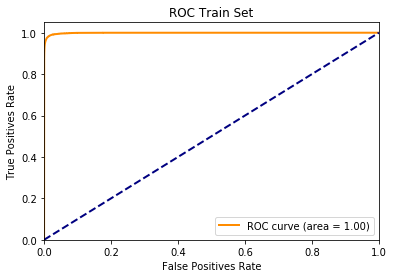

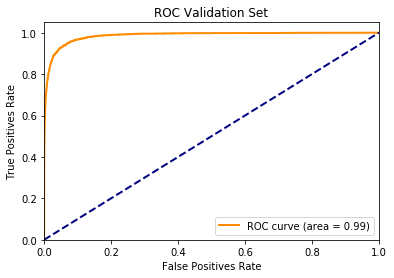

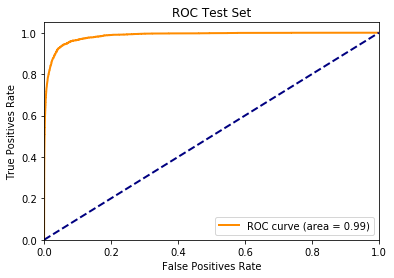

In [129]:
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.title('ROC Train Set')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(fpr_val, tpr_val, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.title('ROC Validation Set')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.title('ROC Test Set')
plt.legend(loc="lower right")
plt.show()

In [130]:
# confusion matrix:
# tn  fp
# fn  tp
# -------
# f1 score: tp / (tp + (fp + fn)/2)
# -------
# acuracy score: (tp + tn) / (tp + fp + tn + fn)
# -------
# recall score: tp / (tp + fn)
# -------
# precision score: tp / (tp + fp)

cm_train = confusion_matrix(train_y, train_pred)
cm_val = confusion_matrix(val_y, val_pred)
cm_test = confusion_matrix(test_y, test_pred)

cm_train_pct = cm_train / cm_train.astype(np.float).sum()
cm_val_pct = cm_val / cm_val.astype(np.float).sum()
cm_test_pct = cm_test / cm_test.astype(np.float).sum()

summary = [
    ['------', 'Train', 'Validation', 'Test'],
    ['confusion matrix', cm_train, cm_val, cm_test],
    ['confusion matrix pct', cm_train_pct, cm_val_pct, cm_test_pct],
    ['f1 score', f1_score(train_y, train_pred), f1_score(val_y, val_pred), f1_score(test_y, test_pred)],
    ['accuracy score', accuracy_score(train_y, train_pred), accuracy_score(val_y, val_pred), accuracy_score(test_y, test_pred)],
    ['recall score', recall_score(train_y, train_pred), recall_score(val_y, val_pred), recall_score(test_y, test_pred)],
    ['precision score', precision_score(train_y, train_pred), precision_score(val_y, val_pred), precision_score(test_y, test_pred)]
]

pretty_table(summary)

------              	Train                    	Validation               	Test                     
confusion matrix    	[[243964   1476]         	[[80563  1034]           	[[80497  1025]           
                    	 [   335   9725]]        	 [  681  2681]]          	 [  685  2621]]          
confusion matrix pct	[[0.95484932 0.00577691] 	[[0.94825739 0.01217058] 	[[0.94894374 0.01208327] 
                    	 [0.00131115 0.03806262]]	 [0.00801563 0.0315564 ]]	 [0.00807516 0.03089782]]
f1 score            	0.9148205634730256       	0.7576656775469832       	0.7540276179516685       
accuracy score      	0.9929119373776908       	0.9798137925352228       	0.9798415617484793       
recall score        	0.9666998011928429       	0.797441998810232        	0.7928009679370841       
precision score     	0.8682260512454245       	0.7216689098250336       	0.7188699945145365       
